In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial,freesans'
from astropy.coordinates import SkyCoord
import numpy as np
import astropy.coordinates
from astropy.coordinates import AltAz, FK5, Galactic
import astropy.units as u
import astropy.time
import xarray as xr
import time
import os
import sys
import multiprocessing
import necstdb
sys.path.append('/home/amigos/otf_yamada/_python_modules/analy_n2data/script')
#sys.path.append("/home/amigos/git/analy_n2data/script")
#import coordinate_calc
from datetime import datetime

In [3]:
path= '/mnt/usbdisk10/analy_n2data/OTF_netcdf/n20200320011353_12CO_2-1_otf_OriKL_revised01.cdf'

In [4]:
data_array = xr.open_dataarray(path)

In [5]:
onmask = data_array['obsmode'] == b'ON        '
hotmask = data_array['obsmode'] == b'HOT       '
offmask = data_array['obsmode'] == b'OFF       '

In [6]:
on_array = data_array[onmask]
off_array = data_array[offmask]
hot_array = data_array[hotmask]

In [7]:
np.unique(off_array['scan_num'])

array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.],
      dtype=float32)

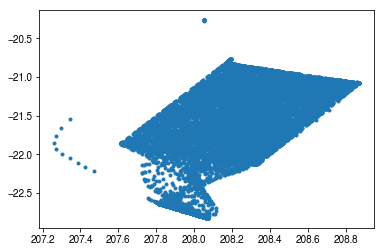

In [8]:
plt.plot(data_array['l_list'], data_array['b_list'], '.')
#plt.ylim(-20, -17)
#plt.xlim(206.5, 209.5)

<xarray.DataArray (t: 18519, spectral_data: 32768)>
[606830592 values with dtype=float32]
Coordinates:
    obsmode   (t) |S12 b'          ' b'          ' ... b'          '
  * t         (t) float64 1.585e+09 1.585e+09 1.585e+09 ... 1.585e+09 1.585e+09
    scan_num  (t) float32 ...
    l_list    (t) float64 nan nan nan nan nan ... 208.2 208.2 208.2 208.2 208.2
    b_list    (t) float64 nan nan nan nan nan ... -20.77 -20.77 -20.77 -20.77
    ra_list   (t) float64 ...
    dec_list  (t) float64 ...
Dimensions without coordinates: spectral_data

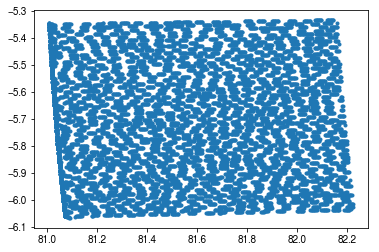

In [10]:
plt.plot(on_array['ra_list'], on_array['dec_list'], '.')
#plt.ylim(-20, -17)
#plt.xlim(206.5, 209.5)

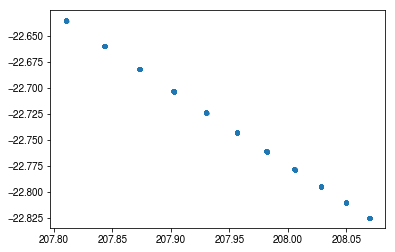

In [13]:
plt.plot(off_array['l_list'], off_array['b_list'], '.')
#plt.ylim(-20, -17)
#plt.xlim(206.5, 209.5)

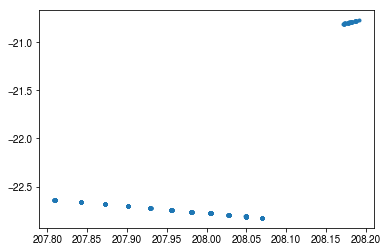

In [14]:
plt.plot(hot_array['l_list'], hot_array['b_list'], '.')
#plt.ylim(-20, -17)
#plt.xlim(206.5, 209.5)

In [15]:
def mean(array):
    mean = array.mean("t", keepdims=True)
    mean["t"] = array.t.mean("t", keepdims=True)
    return mean

def scanmask(array):
    scan_num_list = np.unique(array['scan_num'])
    
    mean_array_list = []
    
    for scan_num in scan_num_list:
        scanmask = array['scan_num'] == scan_num
        scanmasked_array = array[scanmask]        
        scanmasked_array_mean = mean(scanmasked_array)
        
        mean_array_list.append(scanmasked_array_mean)
        mean_array = xr.concat(mean_array_list, dim='t')
    return mean_array

In [16]:
fixed_off_array = scanmask(off_array)
fixed_hot_array = scanmask(hot_array)

(10000000000000.0, 100000000000000.0)

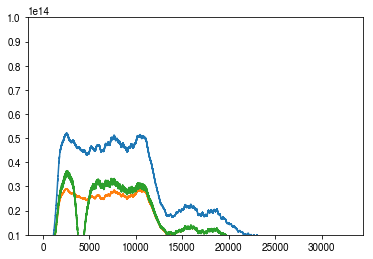

In [19]:
plt.plot(fixed_hot_array[3])
plt.plot(fixed_off_array[3])
plt.plot(on_array[4500])
plt.ylim(1e13, 1e14)

In [116]:
def interp(on_array, off_array, hot_array):
    fixed_off_array = scanmask(off_array)
    fixed_hot_array = scanmask(hot_array)
    reindexed_off_array = off_array.reindex(t=on_array['t'], method='backfill')
    reindexed_hot_array = hot_array.reindex(t=on_array['t'], method='backfill')
    
    return reindexed_off_array, reindexed_hot_array

def chopper_wheel(on_array, reindexed_off_array, reindexed_hot_array):
    
    tastar_array = ((np.array(on_array)-np.array(reindexed_off_array))/(np.array(reindexed_hot_array)-np.array(reindexed_off_array)))*300
    
    return tastar_array

In [117]:
reindexed_off_array, reindexed_hot_array = interp(on_array, off_array, hot_array)

In [118]:
tastar = chopper_wheel(on_array, reindexed_off_array, reindexed_hot_array)

In [119]:
tastar

array([[ 7.9321915e-01,  7.9321915e-01,  7.9321915e-01, ...,
        -1.0921829e+01, -2.4571491e+01, -1.8777203e+01],
       [ 1.1523710e+00,  1.1523710e+00,  1.1523710e+00, ...,
        -2.2410526e+01, -2.5684135e+01,  5.5014629e+00],
       [ 9.4240837e-05,  9.4240837e-05,  9.4240837e-05, ...,
        -3.0777235e+01, -3.0474821e+01, -1.1097055e+01],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]], dtype=float32)

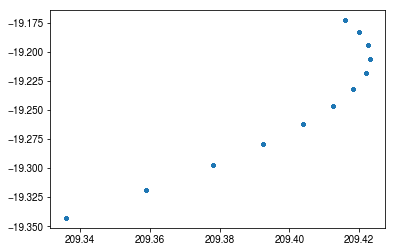

In [68]:
plt.plot(reindexed_off_array['l_list'], reindexed_off_array['b_list'], '.')

(0, 5000)

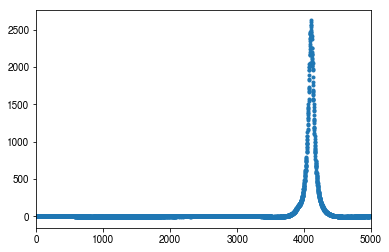

In [133]:
plt.plot(np.nanmean(tastar, axis=0), '.')
plt.xlim(0,5000)
#plt.ylim(-10,40)

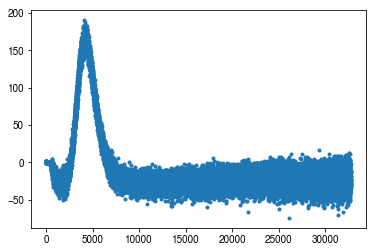

In [131]:
plt.plot(tastar[400] , '.')
#plt.xlim(0,5000)
#plt.ylim(-10,40)

In [67]:
tastar

<xarray.DataArray (t: 9310, spectral_data: 32768)>
array([[-139.05577, -139.05577, -139.05577, ..., -336.71976, -385.8979 ,
        -316.63156],
       [-139.91557, -139.91557, -139.91557, ..., -369.7401 , -415.92697,
        -332.65704],
       [-138.40544, -138.40544, -138.40544, ..., -321.74448, -390.50146,
        -323.5783 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * t        (t) float64 1.585e+09 1.585e+09 1.585e+09 ... 1.585e+09 1.585e+09
Dimensions without coordinates: spectral_data

(-1000, 1000)

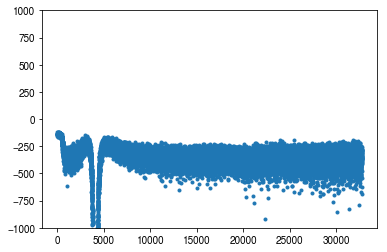

In [58]:
plt.plot(tastar[400], '.')
plt.ylim(-1000, 1000)

In [65]:
tastar = chopper_wheel(on_array, resampled_off, resampled_hot)

(15000, 20000)

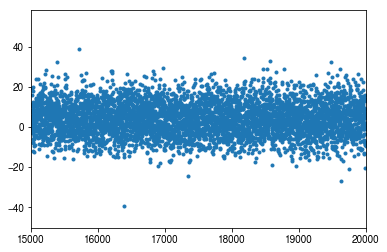

In [28]:
plt.plot(tastar[5000], '.')
plt.xlim(15000, 20000)

In [67]:
onmask = data_array['obsmode'] == b'ON        '

hotmask = data_array['obsmode'] == b'HOT       '
offmask = data_array['obsmode'] == b'OFF       '

In [68]:
np.unique(data_array['obsmode'])

array([b'          ', b'HOT       ', b'OFF       ', b'ON        '],
      dtype='|S12')

In [72]:
off_array = data_array[offmask]
on_array = data_array[onmask]

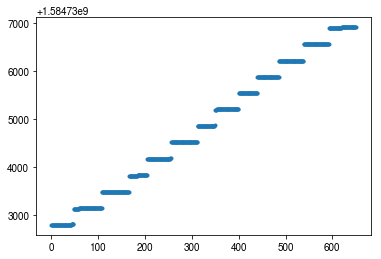

In [70]:
plt.plot(off_array['t'], '.')

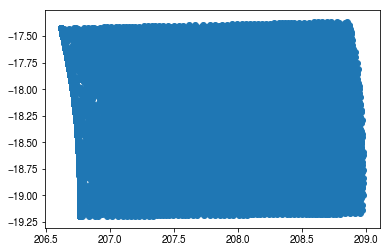

In [79]:
plt.scatter(on_array['l_list'], on_array['b_list'])

(206.5, 209.5)

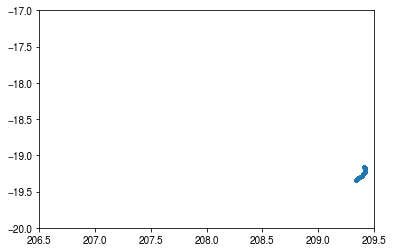

In [71]:
plt.plot(off_array['l_list'], off_array['b_list'], '.')
plt.ylim(-20, -17)
plt.xlim(206.5, 209.5)

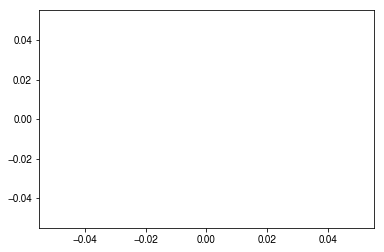

In [52]:
plt.plot(data_off_mean)

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [42]:
data_hot_mean.shape

(32768,)